In [3]:
# импортируем библиотеки необходимые для сбора и дальнейшего анализа данных
import requests
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from textblob import TextBlob
from selenium.webdriver.chrome.service import Service

# модуль поможет убрать предупреждения, которые могут выкидывать некоторые методы
import warnings
warnings.filterwarnings("ignore")

### Тема моего проекта заключается в анализе трилогии фантастического фильма Властелин колец:
**1. 2001 — Властелин колец: Братство Кольца**

**2. 2002 — Властелин колец: Две крепости**

**3. 2003 — Властелин колец: Возвращение короля**

* Будем сравнивать отзывы пользователей на каждый фильм, посмотрим как менялись мнения и настроения зрителей с каждой новой частью;
* Разработаем интерактивные визуализации, которые позволят пользователям исследовать отзывы, настроения и темы.

### Модуль хэдлайнер:
Для классификации настроений будем применять библиотеку **TextBlob** в Python, которая представляет собой процесс определения эмоционального оттенка текста, будь то положительный, нейтральный или отрицательный. TextBlob упрощает работу с текстовыми данными благодаря своему простому API для обработки естественного языка (Natural Language Processing, NLP). Помогать ему в этом будет модуль Selenium при помощи которого соберём данные с сайта imdb.

### Начнём анализ с фильма Властелин колец: Братство Кольца:
Тихая деревня, где живут хоббиты. Придя на 111-й день рождения к своему старому другу Бильбо Бэггинсу, волшебник Гэндальф начинает вести разговор о кольце, которое Бильбо нашел много лет назад. Это кольцо принадлежало когда-то темному властителю Средиземья Саурону, и оно дает большую власть своему обладателю. Теперь Саурон хочет вернуть себе власть над Средиземьем. Бильбо отдает Кольцо племяннику Фродо, чтобы тот отнёс его к Роковой Горе и уничтожил.

### При помощи Selenium спарсим данные с отзывами пользователей с сайта imdb, а при помощи TextBlob распределим отзывы по категориям настроения

In [4]:
# Функция для классификации настроений
def classify_sentiment(review):
    polarity = TextBlob(review).sentiment.polarity
    if polarity > 0.75:
        return 'Очень положительный'
    elif polarity > 0.5:
        return 'Сильно положительный'
    elif polarity > 0.25:
        return 'Умеренно положительный'
    elif polarity > 0:
        return 'Слегка положительный'
    elif polarity > -0.25:
        return 'Слегка отрицательный'
    elif polarity > -0.5:
        return 'Умеренно отрицательный'
    elif polarity > -0.75:
        return 'Сильно отрицательный'
    else:
        return 'Очень отрицательный'

# Настройка WebDriver
s = Service('C:/Users/MAGICAL/Desktop/Python/chromedriver.exe')
driver = webdriver.Chrome(service=s)
driver.get('https://www.imdb.com/title/tt0120737/reviews')

reviews = []
review_dates = []

try:
    for _ in range(5):  # Попытаемся нажать до 5 раз на кнопку "Load More"
        load_more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, '.ipl-load-more__button')))
        driver.execute_script("arguments[0].click();", load_more_button)
        time.sleep(2)

    review_elements = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.text.show-more__control')))
    date_elements = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.review-date')))

    for review_element, date_element in zip(review_elements, date_elements):
        reviews.append(review_element.text.strip())
        review_dates.append(date_element.text.strip())

finally:
    driver.quit()

# Анализируем настроение каждого отзыва
sentiments = [classify_sentiment(review) for review in reviews]

# Создаем датафрейм
df_thefellowshipofthering = pd.DataFrame({
    'Review': reviews,
    'Review_Date': review_dates,
    'Sentiment': sentiments
})

df_thefellowshipofthering 

,Review,Review_Date,Sentiment
0,"Here is one film that lived up to its hype, an...",7 March 2006,Умеренно положительный
1,(95%) If the late 70's early 80's had the Star...,11 November 2014,Слегка положительный
2,,8 August 2020,Слегка отрицательный
3,The first part of the Lord of the Rings trilog...,14 April 2006,Умеренно положительный
4,An incredible feat Enthrals anew every time Ca...,7 March 2021,Сильно положительный
...,...,...,...
145,This film is a triumph in almost every aspect....,7 August 2003,Умеренно положительный
146,This was such a great movie. The whole time it...,23 December 2001,Сильно положительный
147,As a fan of fantasy films since my child hood ...,3 January 2002,Слегка положительный
148,This is one of the few movies I've seen that d...,20 October 2014,Умеренно положительный


### В отзывах на фильмы встречаются как обычные текстовые комментарии, так и отзывы со спойлерами. Исключим из анализа те отзывы, которые содержат спойлеры, и сосредоточимся на анализе только тех комментариев, где спойлеров нет.

In [5]:
# типы колонок
df_thefellowshipofthering.dtypes

Review         object
Review_Date    object
Sentiment      object
dtype: object

In [6]:
# переведём колонку с датой создания отзыва во временной формат
df_thefellowshipofthering['Review_Date'] = pd.to_datetime(df_thefellowshipofthering['Review_Date'])

In [7]:
# удаляем строки не содержащие текстовые данные или пустые
df_thefellowshipofthering_filtered = df_thefellowshipofthering[df_thefellowshipofthering['Review'].apply(lambda x: x.strip() != '')]

In [8]:
# добавим цифровые значения полярности
df_thefellowshipofthering_filtered['Polarity'] = abs(df_thefellowshipofthering_filtered['Review'].apply(lambda x: TextBlob(x).sentiment.polarity))

In [10]:
# добавим размер (длину) отзыва
df_thefellowshipofthering_filtered['Review_Length'] = df_thefellowshipofthering_filtered['Review'].apply(len)

In [16]:
# для более наглядной разбивки извлечём из даты написания отзыва год его написания
df_thefellowshipofthering_filtered['Year_column'] = df_thefellowshipofthering_filtered['Review_Date'].dt.year

In [17]:
# общая таблица
df_thefellowshipofthering_filtered.head()

,Review,Review_Date,Sentiment,Polarity,Review_Length,Year_column
0,"Here is one film that lived up to its hype, an...",2006-03-07,Умеренно положительный,0.253623,1888,2006
1,(95%) If the late 70's early 80's had the Star...,2014-11-11,Слегка положительный,0.246094,1372,2014
3,The first part of the Lord of the Rings trilog...,2006-04-14,Умеренно положительный,0.265238,2575,2006
4,An incredible feat Enthrals anew every time Ca...,2021-03-07,Сильно положительный,0.533333,94,2021
5,It is my firm belief that the standard version...,2020-02-15,Слегка положительный,0.205556,325,2020


In [ ]:
# получаем 129 отзывов
df_thefellowshipofthering_filtered.shape

In [28]:
# среднние данные по полярности в разбивке по году написания отзыва
avg_polarity_frame = df_thefellowshipofthering_filtered.groupby(['Year_column', 'Sentiment']) \
                                  .agg(avg_polarity=('Sentiment', 'count'))

In [13]:
# количество отзывов по категориям
df_reaction_thefellowshipofthering = df_thefellowshipofthering_filtered.groupby('Sentiment', as_index=False) \
                                                                       .agg(all_reaction = ('Review', 'count')) \
                                                                       .sort_values('all_reaction', ascending=False)

In [14]:
# получилось всего 3 категории настроения, с исключительно положительными оценками
df_reaction_thefellowshipofthering

,Sentiment,all_reaction
2,Умеренно положительный,63
1,Слегка положительный,57
0,Сильно положительный,9


### Визуализируем получившиеся результаты

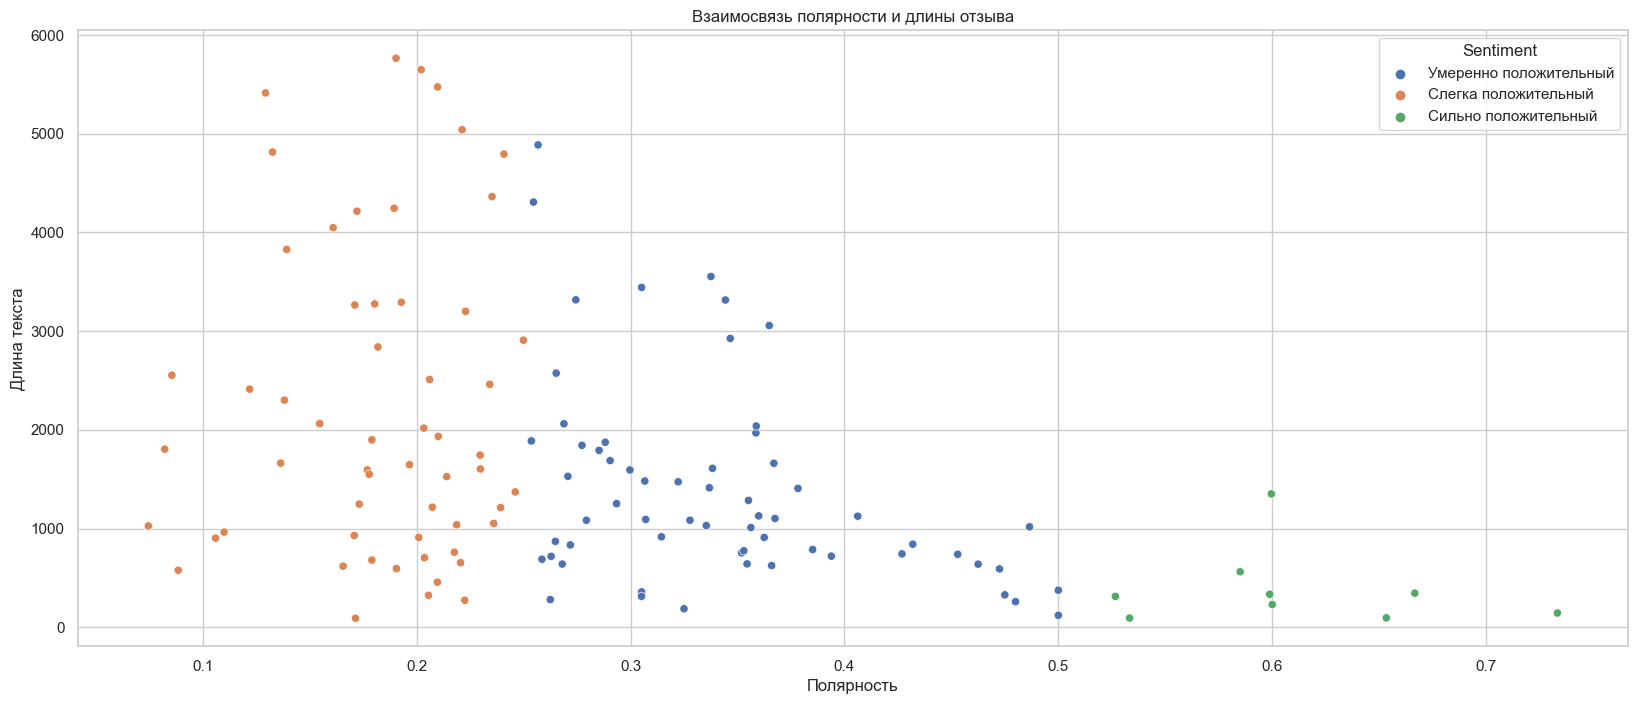

In [20]:
# посмотрим имеется ли взаимосвязь полярности отзывов от длины отзыва
sns.set(rc={'figure.figsize':(20,8)}, style="whitegrid", font='sans-serif')
custom_palette = sns.color_palette(["#AEC6CF", "#FDFD96", "#77DD77", "#C23B22"])
ax = sns.scatterplot(x='Polarity', y='Review_Length', hue='Sentiment', data=df_thefellowshipofthering_filtered)
ax.set(xlabel='Полярность', ylabel='Длина текста', title='The Return Of The King')
plt.title('Взаимосвязь полярности и длины отзыва')
plt.show()

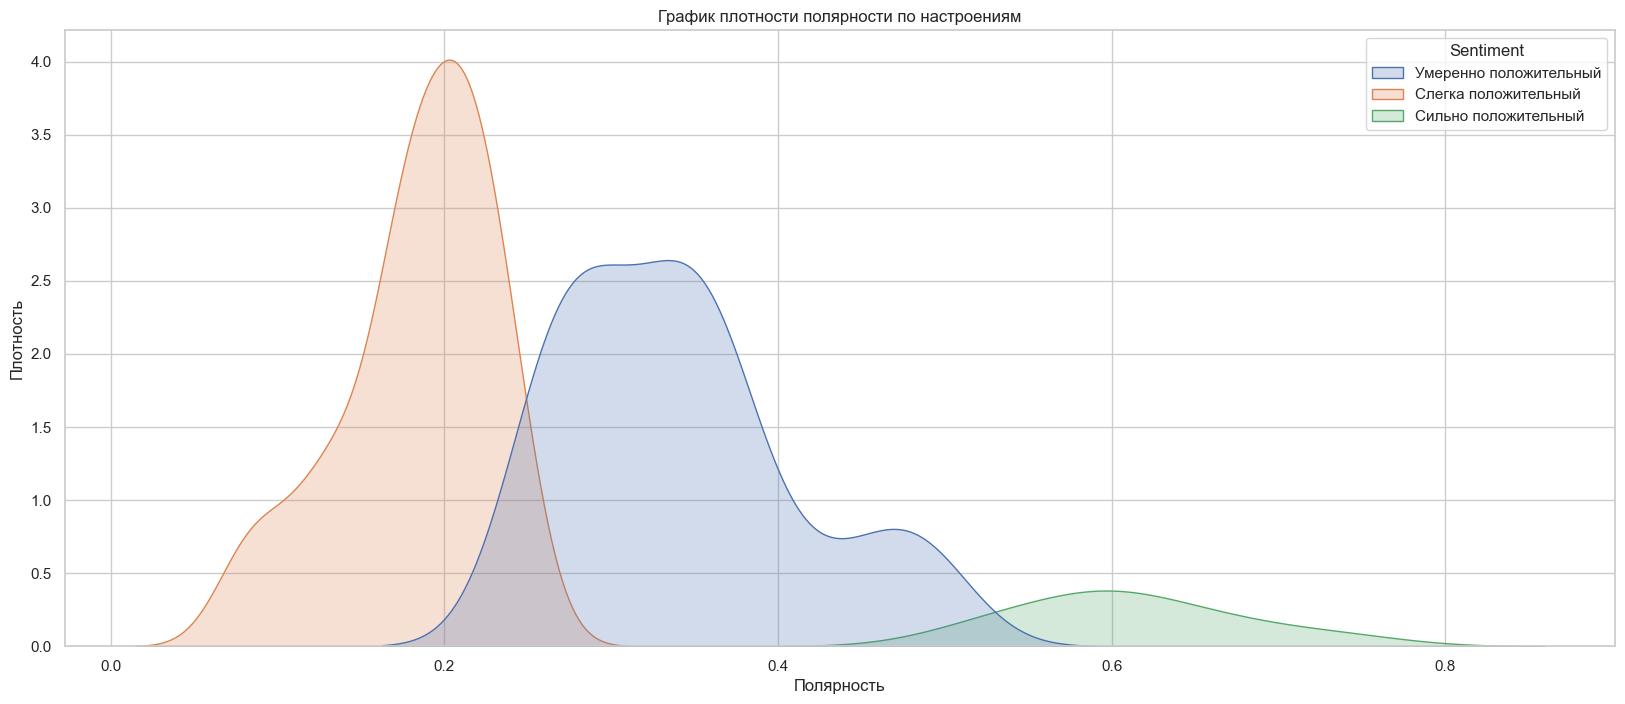

In [17]:
# более наглядный пример с плотностью
ax = sns.kdeplot(data=df_thefellowshipofthering_filtered, x='Polarity', hue='Sentiment', fill=True)
ax.set(xlabel='Полярность', ylabel='Плотность', title='The Return Of The King')
plt.title('График плотности полярности по настроениям')
plt.show()

<Axes: xlabel='Year_column', ylabel='avg_polarity'>

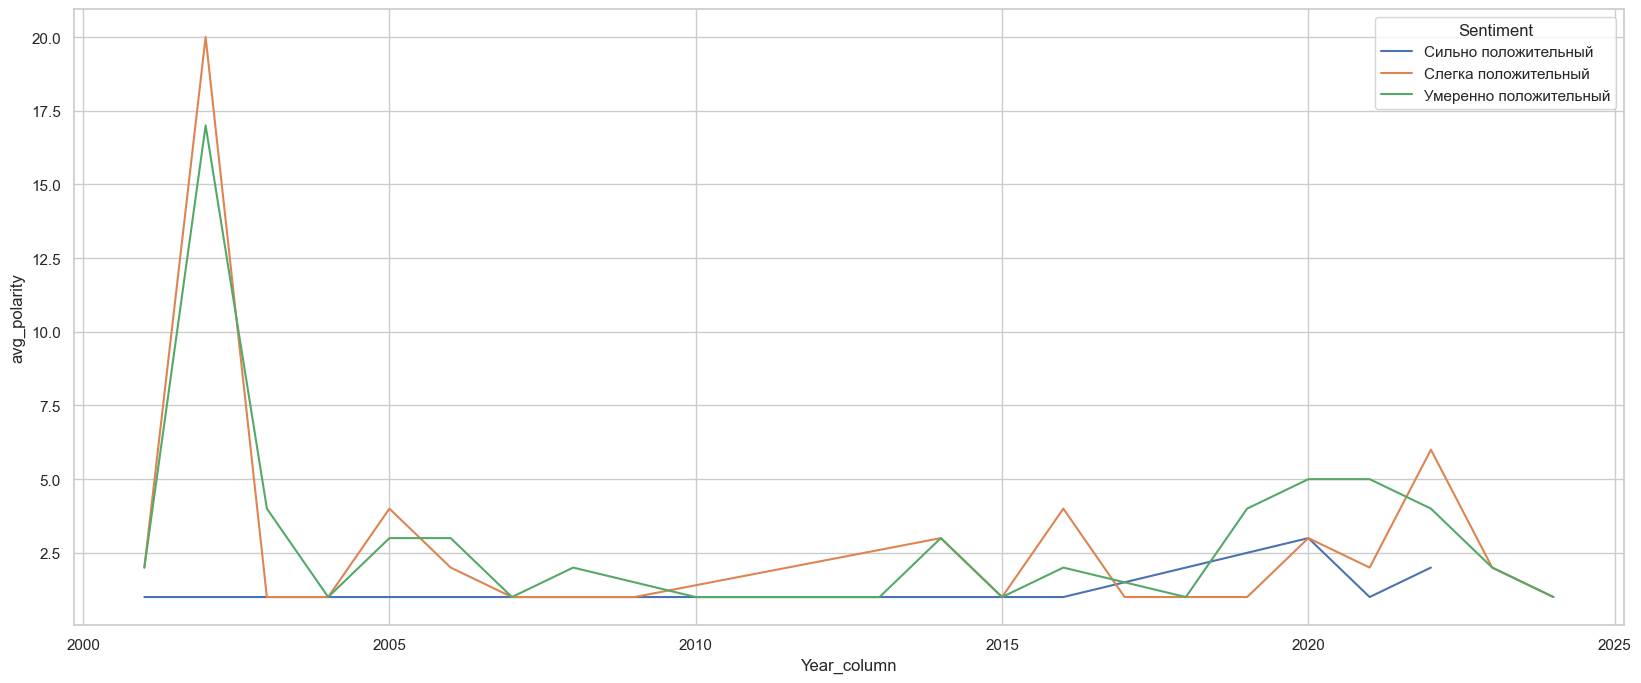

In [31]:
# общее распределение количества категории настроения в разбивке по дате написания отзыва
sns.lineplot(data=avg_polarity_frame, x='Year_column', y='avg_polarity', hue='Sentiment')

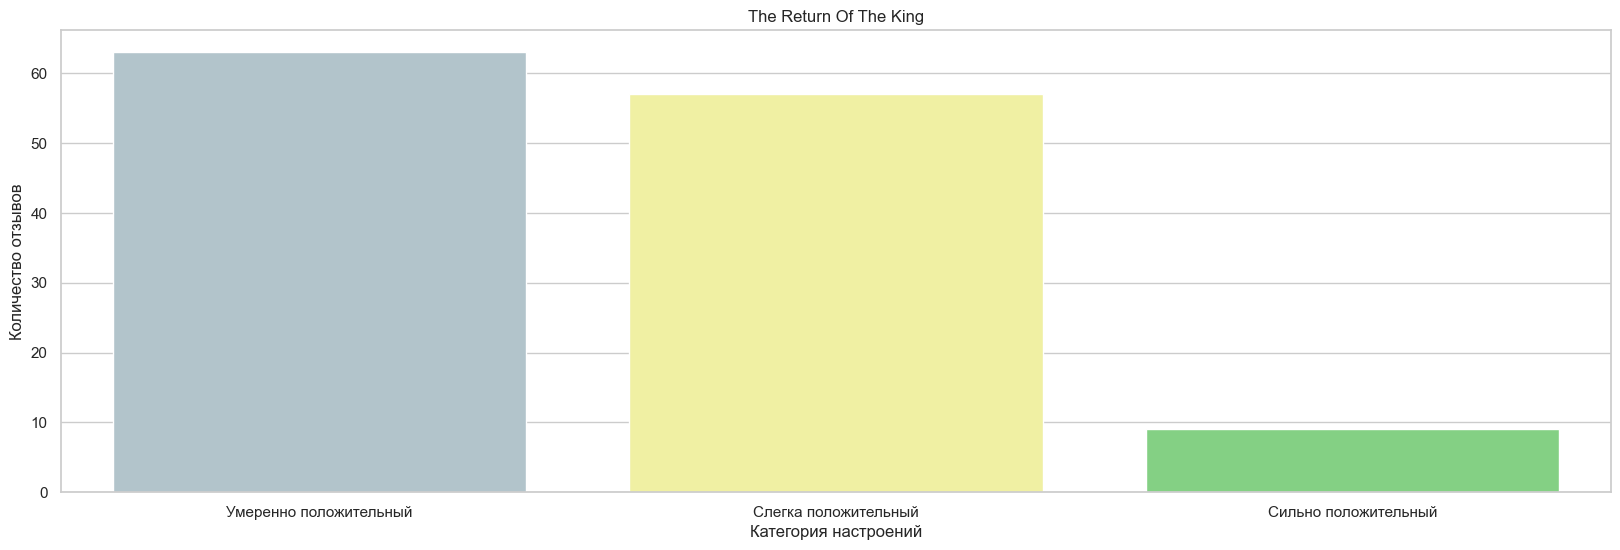

In [91]:
# общее визуальное распределение отзывов по категориям
custom_palette = sns.color_palette(["#AEC6CF", "#FDFD96", "#77DD77", "#C23B22"])
sns.set(rc={'figure.figsize':(20,6)}, style="whitegrid", font='sans-serif', palette=custom_palette)
ax = sns.barplot(x='Sentiment', y='all_reaction', data=df_reaction_thefellowshipofthering, palette=custom_palette)
ax.set(xlabel='Категория настроений', ylabel='Количество отзывов', title='The Return Of The King')
plt.show()

### Промежуточный вывод по фильму Властелин колец: Братство Кольца:
* После изучения 129 различных мнений пользователей, становится ясно, что фильм вызвал в основном положительную реакцию среди зрителей. Большинство откликов указывают на высокое качество кинопроизведения, с минимальным количеством негативных отзывов. Заметно, что доминирующая часть комментариев попадает в категорию "Умеренно положительные", что свидетельствует о благосклонном приятии фильма аудиторией, хотя и с некоторыми оговорками.
* Интересно, что в рамках проведённого анализа обнаружились определённые закономерности. Одна из них заключается в том, что чем кратче текст отзыва, тем выше, как правило, его оценка. Это может свидетельствовать о тенденции пользователей выражать своё восхищение фильмом в более лаконичной форме, в то время как более развернутые комментарии чаще содержат критику или указания на недостатки. Таким образом, краткость отзыва несёт в себе некий позитивный заряд, в то время как детальное изложение мыслей может приводить к более низким оценкам. Эта тенденция предоставляет интересный угол зрения на взаимосвязь между формой представления мнения и его содержательной оценкой.
* Через весь рассматриваемый период количество высокоположительных отзывов оставалось практически неизменным, колеблясь в пределах от нуля до двух. В то же время, наблюдался заметный рост количества отзывов с легко и умеренно положительной окраской в интервале между 2001 и 2003 годами. Вне этого периода количество таких отзывов продолжало изменяться, но эти изменения были менее значительными, ограничиваясь лишь небольшими колебаниями и временными подъемами.

### Властелин колец: Две крепости

In [37]:
# Функция для классификации настроений
def classify_sentiment(review):
    polarity = TextBlob(review).sentiment.polarity
    if polarity > 0.75:
        return 'Очень положительный'
    elif polarity > 0.5:
        return 'Сильно положительный'
    elif polarity > 0.25:
        return 'Умеренно положительный'
    elif polarity > 0:
        return 'Слегка положительный'
    elif polarity > -0.25:
        return 'Слегка отрицательный'
    elif polarity > -0.5:
        return 'Умеренно отрицательный'
    elif polarity > -0.75:
        return 'Сильно отрицательный'
    else:
        return 'Очень отрицательный'

# Настройка WebDriver
s = Service('C:/Users/MAGICAL/Desktop/Python/chromedriver.exe')
driver = webdriver.Chrome(service=s)
driver.get('https://www.imdb.com/title/tt0167261/reviews')

# Собираем отзывы
reviews = []
review_dates = []

try:
    for _ in range(5):  # Попытаемся нажать до 5 раз на кнопку "Load More"
        load_more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, '.ipl-load-more__button')))
        driver.execute_script("arguments[0].click();", load_more_button)
        time.sleep(2)

    review_elements = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.text.show-more__control')))
    date_elements = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.review-date')))

    for review_element, date_element in zip(review_elements, date_elements):
        reviews.append(review_element.text.strip())
        review_dates.append(date_element.text.strip())

finally:
    driver.quit()

# Анализируем настроение каждого отзыва
sentiments = [classify_sentiment(review) for review in reviews]

# Создаем датафрейм
df_thetwotowers = pd.DataFrame({
    'Review': reviews,
    'Review_Date': review_dates,
    'Sentiment': sentiments
})

df_thetwotowers

,Review,Review_Date,Sentiment
0,Peter Jackson truly outdid himself when creati...,12 August 2010,Слегка положительный
1,,28 December 2005,Слегка отрицательный
2,Great movie I really enjoyed watching and bett...,28 September 2020,Сильно положительный
3,"""The Lord of the Rings: The Two Towers"" is ano...",25 March 2003,Умеренно положительный
4,,19 March 2005,Слегка отрицательный
...,...,...,...
144,"This is filled with stunning visuals, of huge ...",22 January 2003,Слегка положительный
145,This trilogy never fails to impress me. Its co...,21 January 2024,Слегка положительный
146,,12 April 2005,Слегка отрицательный
147,It seems ridiculous to want to add my own comm...,18 August 2020,Слегка положительный


In [38]:
# удаляем строки не содержащие текстовые данные или пустые
df_thetwotowers_filtered = df_thetwotowers[df_thetwotowers['Review'].apply(lambda x: x.strip() != '')]

In [44]:
# переведём колонку с датой создания отзыва во временной формат
df_thetwotowers_filtered['Review_Date'] = pd.to_datetime(df_thetwotowers_filtered['Review_Date'])

In [39]:
# добавим цифровые значения полярности
df_thetwotowers_filtered['Polarity'] = abs(df_thetwotowers_filtered['Review'].apply(lambda x: TextBlob(x).sentiment.polarity))

In [40]:
# добавим размер (длину) отзыва
df_thetwotowers_filtered['Review_Length'] = df_thetwotowers_filtered['Review'].apply(len)

In [45]:
# для более наглядной разбивки извлечём из даты написания отзыва год его написания
df_thetwotowers_filtered['Year_column'] = df_thetwotowers_filtered['Review_Date'].dt.year

In [46]:
df_thetwotowers_filtered.head()

,Review,Review_Date,Sentiment,Polarity,Review_Length,Year_column
0,Peter Jackson truly outdid himself when creati...,2010-08-12,Слегка положительный,0.199377,1508,2010
2,Great movie I really enjoyed watching and bett...,2020-09-28,Сильно положительный,0.512500,68,2020
3,"""The Lord of the Rings: The Two Towers"" is ano...",2003-03-25,Умеренно положительный,0.255135,2186,2003
6,Frodo and Sam continue with their dangerous jo...,2023-09-23,Умеренно положительный,0.281238,1072,2023
7,I do love all three films of The Lord of the R...,2011-03-08,Умеренно положительный,0.338294,1660,2011


In [47]:
# получаем 109 отзывов
df_thetwotowers_filtered.shape

(109, 6)

In [53]:
# количество отзывов по категориям
two_towers_reaction = df_thetwotowers_filtered.groupby('Sentiment', as_index=False) \
           .agg(all_reaction = ('Review', 'count')) \
           .sort_values('all_reaction', ascending=False)

In [57]:
number_review_frame_two = df_thetwotowers_filtered.groupby(['Year_column', 'Sentiment']) \
                                  .agg(number_review=('Sentiment', 'count'))

### Визуализируем получившиеся результаты

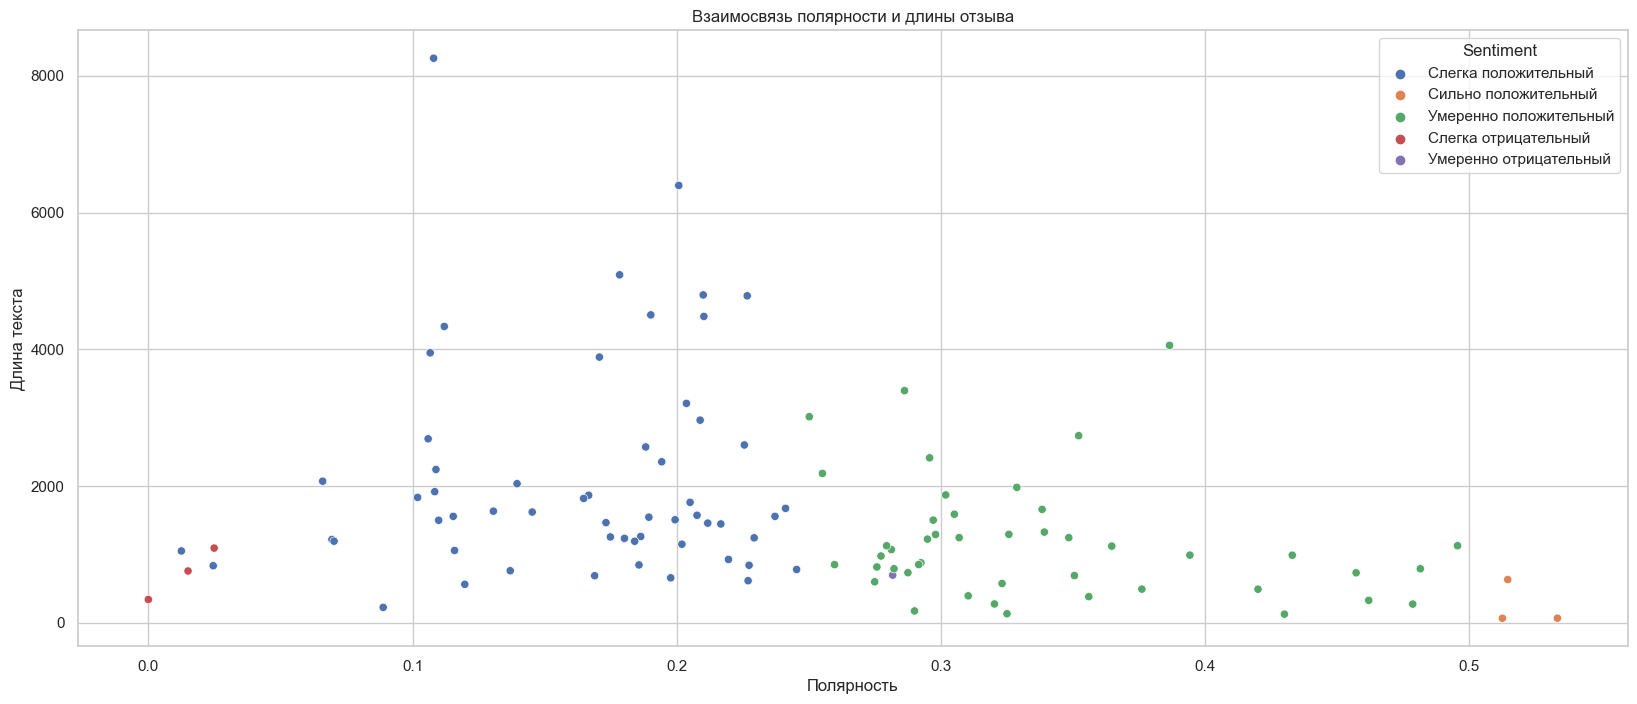

In [65]:
# посмотрим имеется ли взаимосвязь полярности отзывов от длины отзыва
sns.set(rc={'figure.figsize':(20,8)}, style="whitegrid", font='sans-serif')
custom_palette = sns.color_palette(["#AEC6CF", "#FDFD96", "#77DD77", "#C23B22"])
ax = sns.scatterplot(x='Polarity', y='Review_Length', hue='Sentiment', data=df_thetwotowers_filtered)
ax.set(xlabel='Полярность', ylabel='Длина текста')
plt.title('Взаимосвязь полярности и длины отзыва')
plt.show()

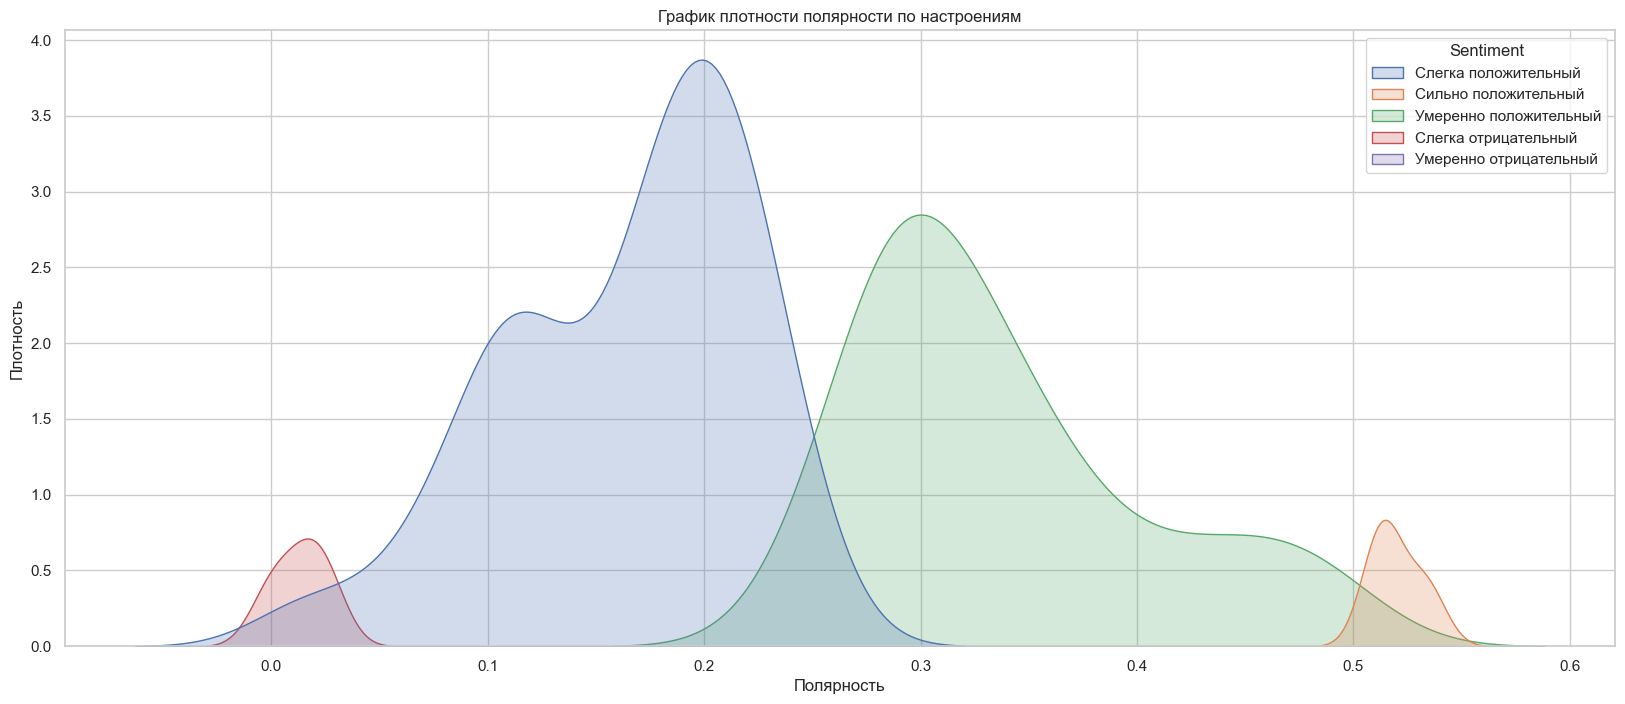

In [63]:
# более наглядный пример с плотностью
ax = sns.kdeplot(data=df_thetwotowers_filtered, x='Polarity', hue='Sentiment', fill=True)
ax.set(xlabel='Полярность', ylabel='Плотность')
plt.title('График плотности полярности по настроениям')
plt.show()

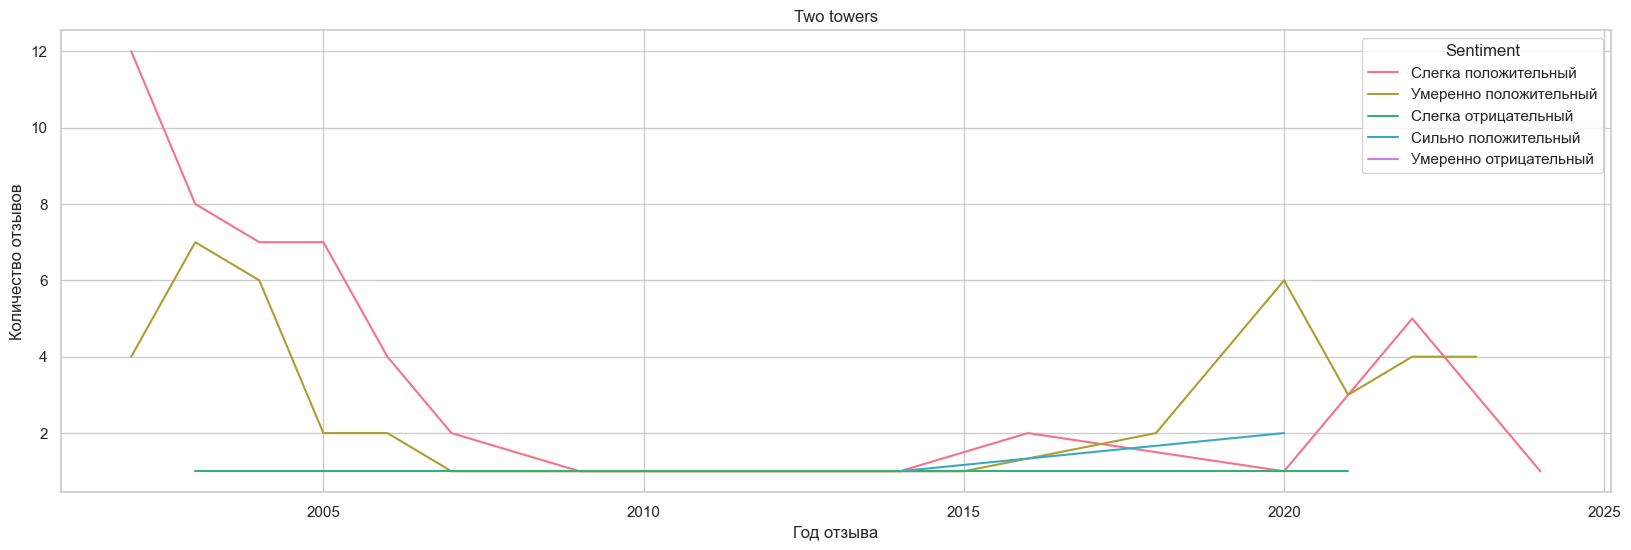

In [61]:
# общее распределение количества категории настроения в разбивке по дате написания отзыва
ax = sns.lineplot(data=number_review_frame_two, x='Year_column', y='number_review', hue='Sentiment')
ax.set(xlabel='Год отзыва', ylabel='Количество отзывов', title='Two towers')
plt.show()

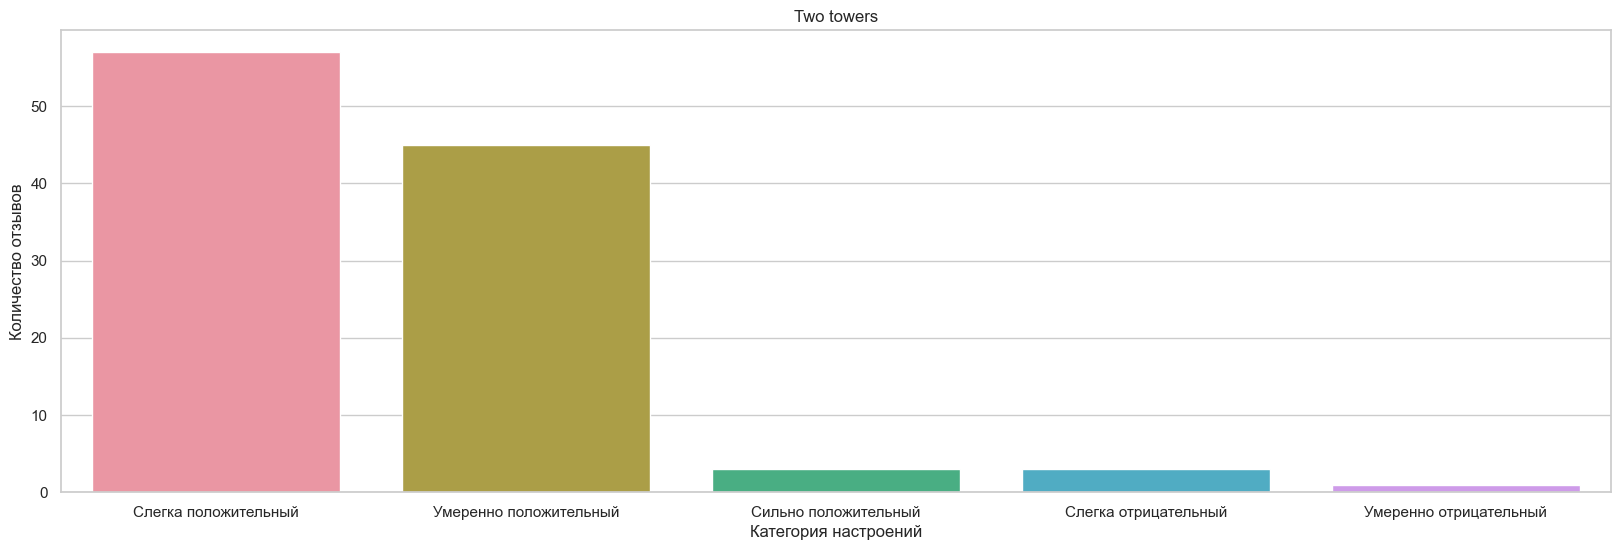

In [64]:
# посмотрим на визуальное распределение отзывов по категориям
custom_palette = sns.color_palette(["#AEC6CF", "#FDFD96", "#77DD77", "#C23B22"])
sns.set(rc={'figure.figsize':(20,6)}, style="whitegrid", font='sans-serif', palette=custom_palette)
ax = sns.barplot(x='Sentiment', y='all_reaction', data=two_towers_reaction)
ax.set(xlabel='Категория настроений', ylabel='Количество отзывов', title='Two towers')
plt.show()

### Промежуточный вывод по фильму Властелин колец: Две крепости:
* В откликах на вторую часть фильма уже заметен рост числа неодобрительных мнений. Отзывы с умеренным и слабым негативом занимают заметную долю от общего числа рецензий. Тем не менее, положительные оценки продолжают преобладать, среди которых наибольшее количество составляют те, что выражают легкую поддержку. Наблюдается та же тенденция, что и в первой части, связанная с корреляцией между длиной отзыва и его эмоциональным оттенком: краткие комментарии склонны быть более позитивными, в то время как более объёмные чаще содержат критику.

* Заметна тенденция: категории "Слегка положительный" и "Умеренно положительный" отзывы демонстрируют значительный рост между 2001 и 2003 годами. После чего количество отзывов этих категорий возвращается к более умеренным значениям с некоторыми колебаниями."Сильно положительные" отзывы поддерживают стабильный уровень на протяжении всего периода с небольшими колебаниями в диапазоне от 0 до 2. Это указывает на то, что несмотря на временные изменения в других категориях, крайне позитивное восприятие оставалось относительно неизменным. В то же время, "Слегка отрицательные" и "Умеренно отрицательные" отзывы представлены в значительно меньшем количестве, что может указывать на общее положительное восприятие того, о чем идет речь на графике.

### Властелин колец: Возвращение короля

In [55]:
# Функция для классификации настроений
def classify_sentiment(review):
    polarity = TextBlob(review).sentiment.polarity
    if polarity > 0.75:
        return 'Очень положительный'
    elif polarity > 0.5:
        return 'Сильно положительный'
    elif polarity > 0.25:
        return 'Умеренно положительный'
    elif polarity > 0:
        return 'Слегка положительный'
    elif polarity > -0.25:
        return 'Слегка отрицательный'
    elif polarity > -0.5:
        return 'Умеренно отрицательный'
    elif polarity > -0.75:
        return 'Сильно отрицательный'
    else:
        return 'Очень отрицательный'

# Настройка WebDriver
s = Service('C:/Users/MAGICAL/Desktop/Python/chromedriver.exe')
driver = webdriver.Chrome(service=s)
driver.get('https://www.imdb.com/title/tt0167260/reviews')

# Собираем отзывы
reviews = []
review_dates = []

try:
    for _ in range(5):  # Попытаемся нажать до 5 раз на кнопку "Load More"
        load_more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, '.ipl-load-more__button')))
        driver.execute_script("arguments[0].click();", load_more_button)
        time.sleep(2)

    review_elements = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.text.show-more__control')))
    date_elements = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.review-date')))

    for review_element, date_element in zip(review_elements, date_elements):
        reviews.append(review_element.text.strip())
        review_dates.append(date_element.text.strip())

finally:
    driver.quit()

# Анализируем настроение каждого отзыва
sentiments = [classify_sentiment(review) for review in reviews]

# Создаем датафрейм
df_thereturnoftheking = pd.DataFrame({
    'Review': reviews,
    'Review_Date': review_dates,
    'Sentiment': sentiments
})

df_thereturnoftheking

,Review,Review_Date,Sentiment
0,Best movie in the trilogy and sealed in the be...,28 September 2020,Сильно положительный
1,All the threads of Tolkien's magnum opus come ...,22 November 2006,Слегка положительный
2,Nothing even comes close and I may well not se...,11 February 2022,Умеренно положительный
3,The greatest tragedy of the human race is that...,2 November 2020,Умеренно положительный
4,"I admit it, I love all three Lord of the Rings...",9 March 2011,Умеренно положительный
...,...,...,...
145,What a breathtaking end to an epic saga that w...,15 October 2017,Слегка положительный
146,...I wasn't sure anyone would have ever guesse...,3 August 2005,Слегка положительный
147,A lot of people looking on this page will thor...,29 April 2009,Умеренно положительный
148,It took J.R.R. Tolkien twelve years to complet...,13 December 2005,Слегка положительный


In [66]:
# удаляем строки не содержащие текстовые данные или пустые
df_thereturnoftheking_filtered = df_thereturnoftheking[df_thereturnoftheking['Review'].apply(lambda x: x.strip() != '')]

In [71]:
# переведём колонку с датой создания отзыва во временной формат
df_thereturnoftheking_filtered['Review_Date'] = pd.to_datetime(df_thereturnoftheking_filtered['Review_Date'])

In [72]:
# добавим цифровые значения полярности
df_thereturnoftheking_filtered['Polarity'] = abs(df_thereturnoftheking_filtered['Review'].apply(lambda x: TextBlob(x).sentiment.polarity))

In [73]:
df_thereturnoftheking_filtered['Review_Length'] = df_thereturnoftheking_filtered['Review'].apply(len)

In [74]:
# для более наглядной разбивки извлечём из даты написания отзыва год его написания
df_thereturnoftheking_filtered['Year_column'] = df_thereturnoftheking_filtered['Review_Date'].dt.year

In [87]:
df_thereturnoftheking_filtered.head()

,Review,Review_Date,Sentiment,Polarity,Review_Length,Year_column
0,Best movie in the trilogy and sealed in the be...,2020-09-28,Сильно положительный,0.666667,61,2020
1,All the threads of Tolkien's magnum opus come ...,2006-11-22,Слегка положительный,0.186645,2459,2006
2,Nothing even comes close and I may well not se...,2022-02-11,Умеренно положительный,0.374286,684,2022
3,The greatest tragedy of the human race is that...,2020-11-02,Умеренно положительный,0.500000,107,2020
4,"I admit it, I love all three Lord of the Rings...",2011-03-09,Умеренно положительный,0.376751,2409,2011


In [76]:
# получаем 117 отзывов
df_thereturnoftheking_filtered.shape

(117, 6)

In [78]:
# количество отзывов по категориям
reaction_return = df_thereturnoftheking_filtered_group = df_thereturnoftheking_filtered.groupby('Sentiment', as_index=False) \
           .agg(all_reaction = ('Review', 'count')) \
           .sort_values('all_reaction', ascending=False)

In [80]:
reaction_return

,Sentiment,all_reaction
3,Слегка положительный,53
4,Умеренно положительный,48
1,Сильно положительный,7
2,Слегка отрицательный,5
0,Очень положительный,4


In [89]:
number_review_return = df_thereturnoftheking_filtered.groupby(['Year_column', 'Sentiment']) \
                                  .agg(number_review=('Sentiment', 'count'))

In [88]:
number_review_return.head()

number_review
Year_column Sentiment                            
2003        Слегка положительный                8
            Умеренно положительный              1
2004        Слегка положительный                3
            Умеренно положительный              2
2005        Слегка положительный                8

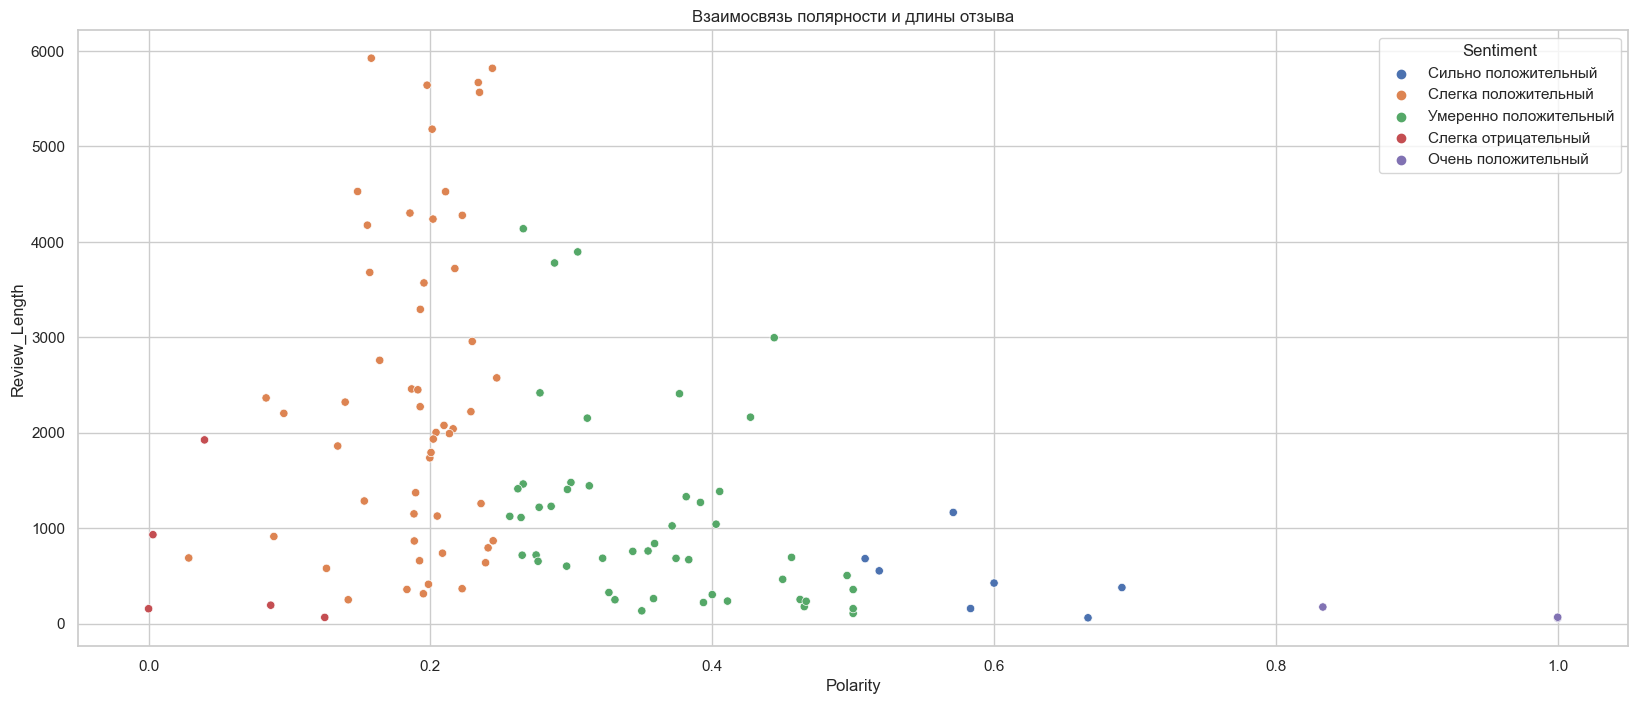

In [83]:
# Предположим, у вас есть колонка 'Length' с длиной отзыва
sns.scatterplot(x='Polarity', y='Review_Length', hue='Sentiment', data=df_thereturnoftheking_filtered)
plt.title('Взаимосвязь полярности и длины отзыва')
plt.show()


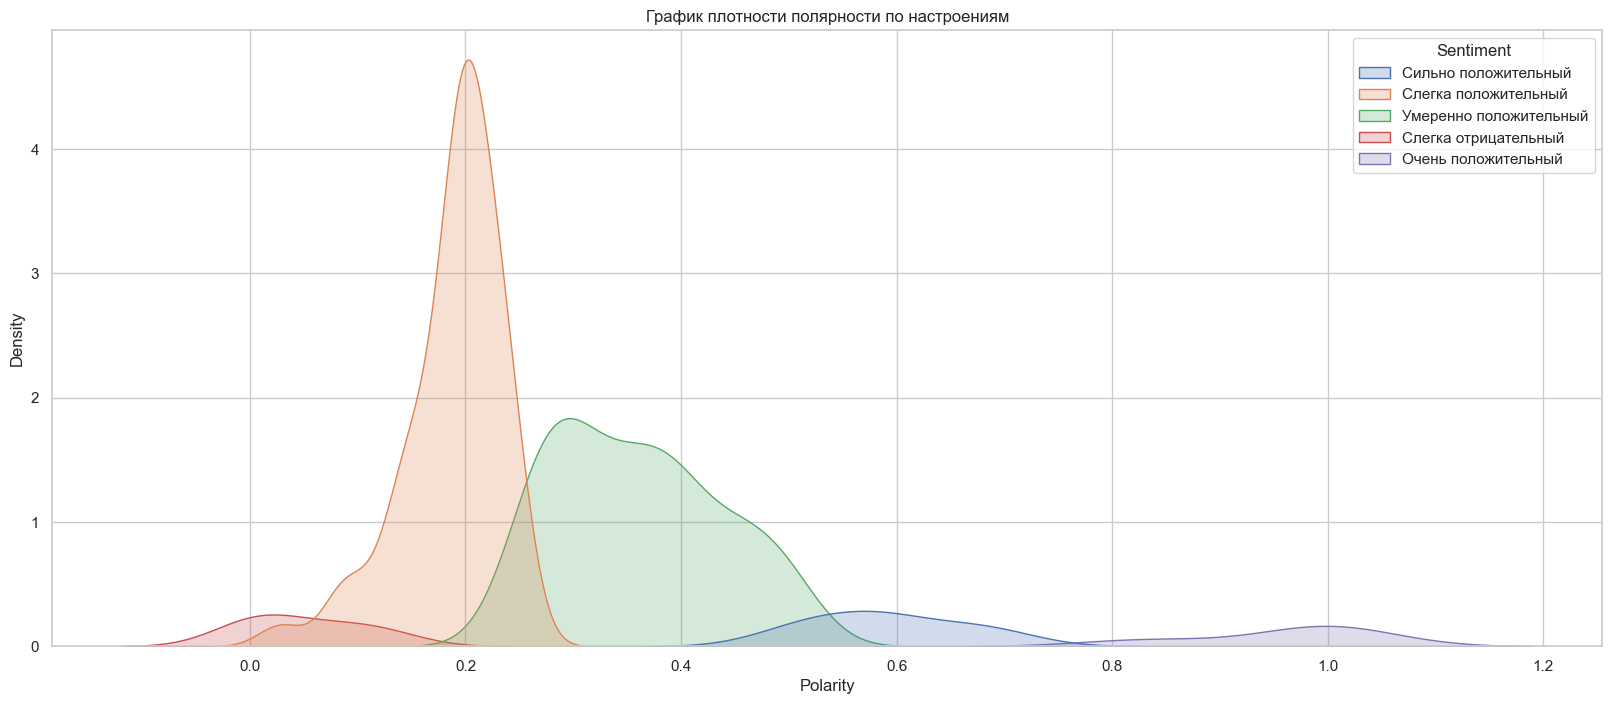

In [84]:
sns.kdeplot(data=df_thereturnoftheking_filtered, x='Polarity', hue='Sentiment', fill=True)
plt.title('График плотности полярности по настроениям')
plt.show()

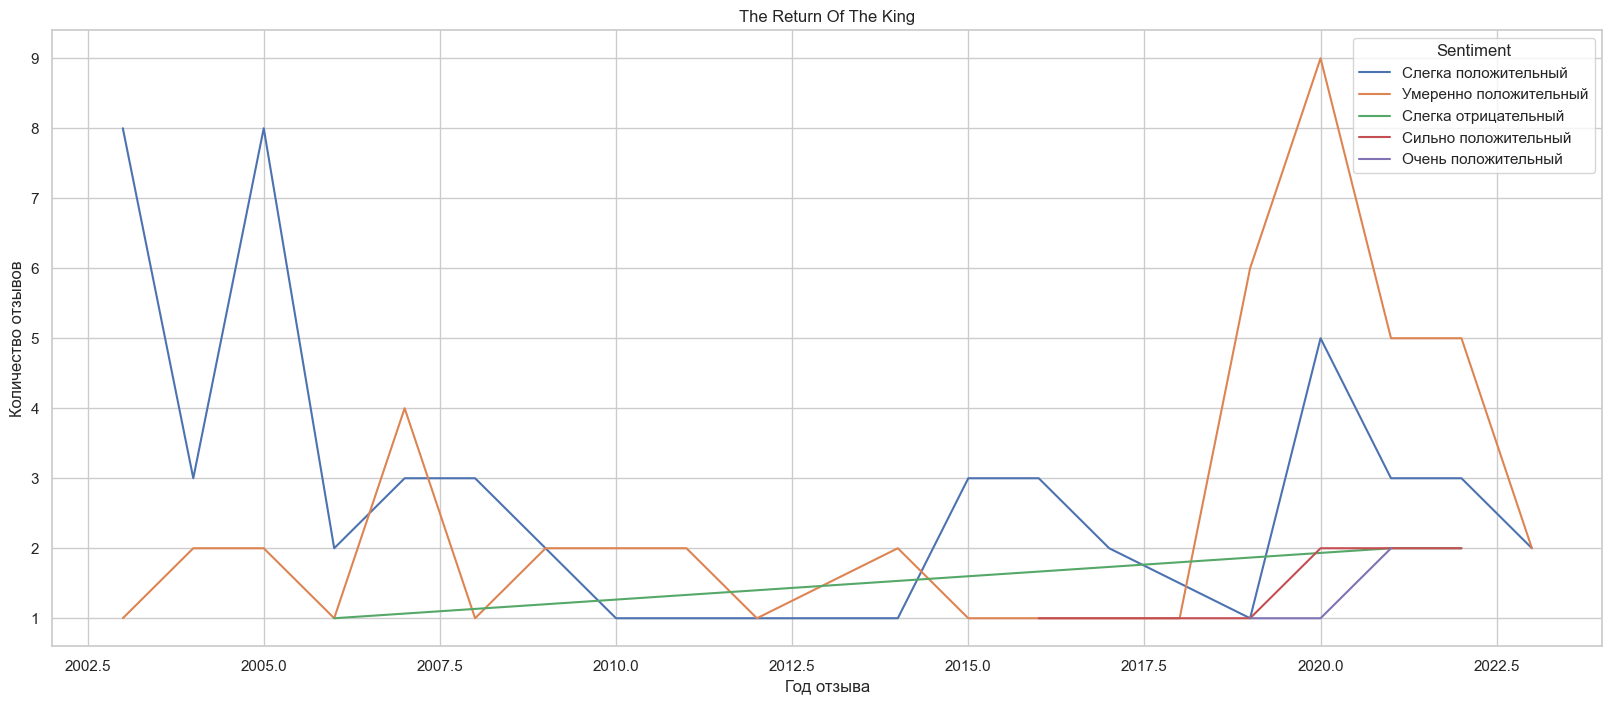

In [85]:
# общее распределение количества категории настроения в разбивке по дате написания отзыва
ax = sns.lineplot(data=number_review_return, x='Year_column', y='number_review', hue='Sentiment')
ax.set(xlabel='Год отзыва', ylabel='Количество отзывов', title='The Return Of The King')
plt.show()

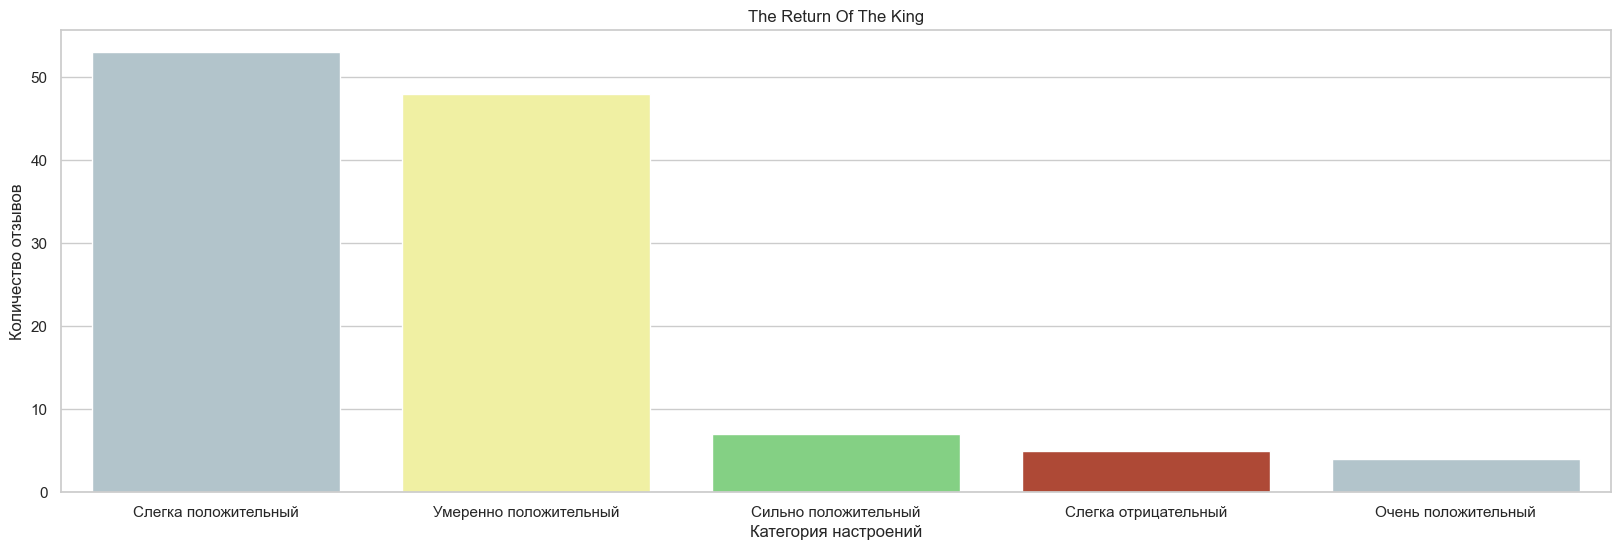

In [86]:
# посмотрим на визуальное распределение отзывов по категориям
sns.set(rc={'figure.figsize':(20,6)}, style="whitegrid", font='sans-serif')
custom_palette = sns.color_palette(["#AEC6CF", "#FDFD96", "#77DD77", "#C23B22"])
ax = sns.barplot(x='Sentiment', y='all_reaction', data=df_thereturnoftheking_filtered_group, palette=custom_palette)
ax.set(xlabel='Категория настроений', ylabel='Количество отзывов', title='The Return Of The King')
plt.show()

### Промежуточные вывод по фильму Властелин колец: Возвращение короля:
* Виден явный пик в категории "Очень положительных" отзывов около 2020 года, что указывает на значительный всплеск в восприятии фильма крайне положительно в этот период. "Сильно положительные" отзывы также присутствуют, но их количество меньше и распределено более равномерно по времени. Категории "Слегка положительных" и "Умеренно положительных" отзывов демонстрируют более низкую, но стабильную активность, при этом "Слегка положительные" являются наиболее частыми на протяжении всего периода. Это подчеркивает общий положительный прием фильма, несмотря на наличие некоторого числа "Слегка отрицательных" отзывов, которые также распределены во времени, но их количество значительно меньше. "Умеренно отрицательные" отзывы практически отсутствуют, что может свидетельствовать о том, что фильм в целом хорошо воспринят аудиторией, и крайние случаи недовольства являются скорее исключением, чем правилом.
* Определенна прослеживается также взаимосвязь между длинной текста и настроением отзыва, как и в предыдущих двух фильмах.

### Общие выводы:

На основе анализа отзывов о трилогии "Властелин колец", можно сделать несколько ключевых наблюдений:

* "Братство Кольца" вызвало преимущественно положительный отклик среди аудитории, с тенденцией к умеренно положительным оценкам. Это говорит о том, что фильм получил одобрение большинства зрителей, хоть и с определенными резервами.

* "Две крепости" сохранили общую положительную динамику рецензий, хотя и зафиксировано увеличение отрицательных отзывов. Тем не менее, доминирование положительных оценок указывает на успешное продолжение эпопеи, которая продолжала удерживать внимание и интерес зрителей.

* "Возвращение короля" заметно выделяется существенным пиком очень положительных отзывов, особенно выраженным в 2020 году, что может свидетельствовать о возобновленном интересе к фильму или особом событии, связанном с ним в этот период.

Поперечное исследование всех трех фильмов выявило интересную закономерность: краткие отзывы чаще оказывались положительными, в то время как более длинные тексты склонны содержать более нюансированные или критические замечания. Это подчеркивает тенденцию зрителей к более эмоциональной и сжатой похвале, в отличие от более обдуманных и развернутых критических высказываний.

Общий вывод можно сформулировать так: трилогия "Властелин колец" в целом имеет сильную положительную репутацию среди аудитории, с постепенным снижением интенсивности восторженных отзывов к середине, но с последующим значительным возвышением к финальной части. Взаимосвязь между длиной и тоном отзыва является значимым аспектом обратной связи зрителей, указывая на различные подходы к выражению мнений о кино.
